In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Load the CSV file
CSV_PATH = 'sample_labels.csv.csv'
IMAGE_PATH = 'images'

df = pd.read_csv(CSV_PATH)

# Define image size
IMG_SIZE = (150, 150)

# Load images and preprocess
def load_images(df, img_path, img_size, limit=None):
    images = []
    labels = []
    count = 0
    for index, row in df.iterrows():
        if limit and count >= limit:
            break
        img_name = row['Image Index']
        img_path_full = os.path.join(img_path, img_name)
        img = cv2.imread(img_path_full)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(row['Finding Labels'])
            count += 1
            if count % 100 == 0:  # Print progress every 100 images
                print(f"Loaded {count} images")
        else:
            print(f'Error loading image: {img_path_full}')  # Debug statement
    return np.array(images), np.array(labels)

# Limit to first 500 images for initial debugging
images, labels = load_images(df, IMAGE_PATH, IMG_SIZE, limit=500)

# Check if images and labels are not empty
if len(images) == 0:
    raise ValueError("No images loaded. Check the IMAGE_PATH and CSV file for correct filenames and paths.")

# Convert labels to categorical (multi-class)
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform([label.split('|') for label in labels])

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")


Loaded 100 images
Loaded 200 images
Loaded 300 images
Loaded 400 images
Loaded 500 images
Training data shape: (400, 150, 150, 3)
Validation data shape: (100, 150, 150, 3)
Training labels shape: (400, 14)
Validation labels shape: (100, 14)


Step 2: Build and Train the CNN Model

c:\Users\sharm\anaconda3\envs\dev\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step - accuracy: 0.3816 - loss: 0.3780 - val_accuracy: 0.6400 - val_loss: 0.2353
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 631ms/step - accuracy: 0.5214 - loss: 0.2633 - val_accuracy: 0.6400 - val_loss: 0.2020
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 599ms/step - accuracy: 0.5375 - loss: 0.2521 - val_accuracy: 0.6400 - val_loss: 0.2035
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 608ms/step - accuracy: 0.5486 - loss: 0.2290 - val_accuracy: 0.5700 - val_loss: 0.2045
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 603ms/step - accuracy: 0.5245 - loss: 0.2370 - val_accuracy: 0.5500 - val_loss: 0.2036
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 591ms/step - accuracy: 0.5973 - loss: 0.1961 - val_accuracy: 0.5500 - val_loss: 0.2054
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - accuracy: 0.5710 - loss: 0.1944 - val_accuracy: 0.5700 - val_loss: 0.2102
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 549ms/step - accuracy: 0.6330 - loss: 0.1701 - val_accuracy: 0

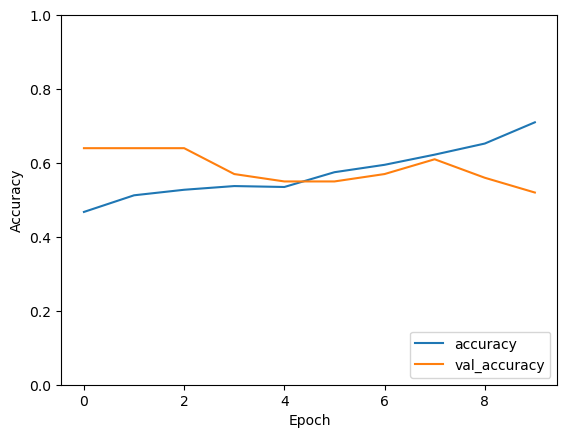

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Multi-label classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Save the model
model.save('disease_detection_model.h5')


In [16]:
# Save the model in the new Keras format
model.save('disease_detection_model.keras')


In [17]:
pip install Flask tensorflow numpy


Note: you may need to restart the kernel to use updated packages.


# Steps to Run the Flask App
# Ensure you have the Flask application ready (app.py):

In [15]:
from flask import Flask, request, render_template
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os

app = Flask(__name__)

# Load the trained model
model = load_model('disease_detection_model.keras')
print("Model loaded successfully")  # Debugging log

# Define image size and classes
IMG_SIZE = (150, 150)
mlb_classes = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']  # Replace with your actual classes

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        try:
            print("Received POST request")  # Log
            # Get the file from the post request
            f = request.files['file']
            print(f"Received file: {f.filename}")  # Log
            
            # Save the file to ./uploads
            file_path = os.path.join('uploads', f.filename)
            os.makedirs('uploads', exist_ok=True)
            f.save(file_path)
            print(f"Saved file to {file_path}")  # Log
            
            # Make prediction
            img = image.load_img(file_path, target_size=IMG_SIZE)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            print("Prepared image for prediction")  # Log
            
            predictions = model.predict(img_array)[0]
            predicted_labels = [mlb_classes[i] for i in range(len(predictions)) if predictions[i] > 0.5]
            print(f"Predicted labels: {predicted_labels}")  # Log
            
            return render_template('result.html', labels=predicted_labels)
        except Exception as e:
            print(f"Error: {str(e)}")  # Log
            return str(e)
    return render_template('upload.html')

if __name__ == '__main__':
    app.run(debug=True)


Model loaded successfully
 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (windowsapi)


SystemExit: 1